In [1]:
import torch
from Classifier_NN import Classifier_CIFAR
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from NObSP_Decomposition import NObSP_NN_single_MultiOutput
import torch.nn.functional as F

In [2]:
# Cargar los tensores guardados
output_tensors = torch.load('train_tensors_v2.pth')
y = torch.load('train_labels_v2.pth')

X = torch.cat(output_tensors).detach()
y = F.one_hot(torch.cat(y))

labels = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
X_sample = []
y_sample = []

sample_size = 100
# Supongamos que 'num_classes' es el número de clases en tus etiquetas
for i in range(10):
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    X_sample.append(X[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

X = torch.cat(X_sample)
y = torch.cat(y_sample)

In [4]:
X

tensor([[ -2.2101,   3.6295,  -3.2909,  ...,  -5.6893,  -5.5305,  -1.9085],
        [ -3.8799,   9.0099,  -4.8900,  ..., -12.2927, -12.1004,  -3.9643],
        [ -1.4002,   3.3656,  -2.8976,  ...,  -4.8415,  -2.2044,  -1.3508],
        ...,
        [  0.5015,  -0.8875,   3.1736,  ...,  -0.6712,  -3.8767,  -2.6117],
        [ -1.1258,   1.4313,   0.7057,  ...,  -1.9313,   0.2553,  -1.3295],
        [  3.2039,   0.7694,   4.0705,  ...,  -0.6636,  -8.0867,  -2.8425]])

In [5]:
y

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1]])

# Ejecutando el algoritmo

In [6]:
N = np.size(X,0); # Defining the number of datapoints
in_feat = np.size(X,1)

In [7]:
t = np.arange(0, N)
train_split = int(0.8 * N)
p = 10

In [8]:
epochs = 100
learning_rate = 0.001

In [9]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_split,
                                                    random_state=42) 


## Creating model for single nonlinear effects

model_1 = Classifier_CIFAR() # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training loop for the model 1

In [10]:
for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_prob, x_p, y_lin = model_1(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.30085 | test Loss: 2.29435


In [11]:
model_1.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = model_1(
        X
    )  # Computing the nonlinear transformation of the input data X

P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single_MultiOutput(
    X, y_est_1, model_1
)  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer

y_e_Alpha_1 = np.zeros((N, in_feat, p))
for i in range(p):
    y_e_Alpha_1[:, :, i] = (
        x_trans_total_1 @ Alpha_NN_1[:, i * in_feat : i * in_feat + in_feat]
    )  # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu()

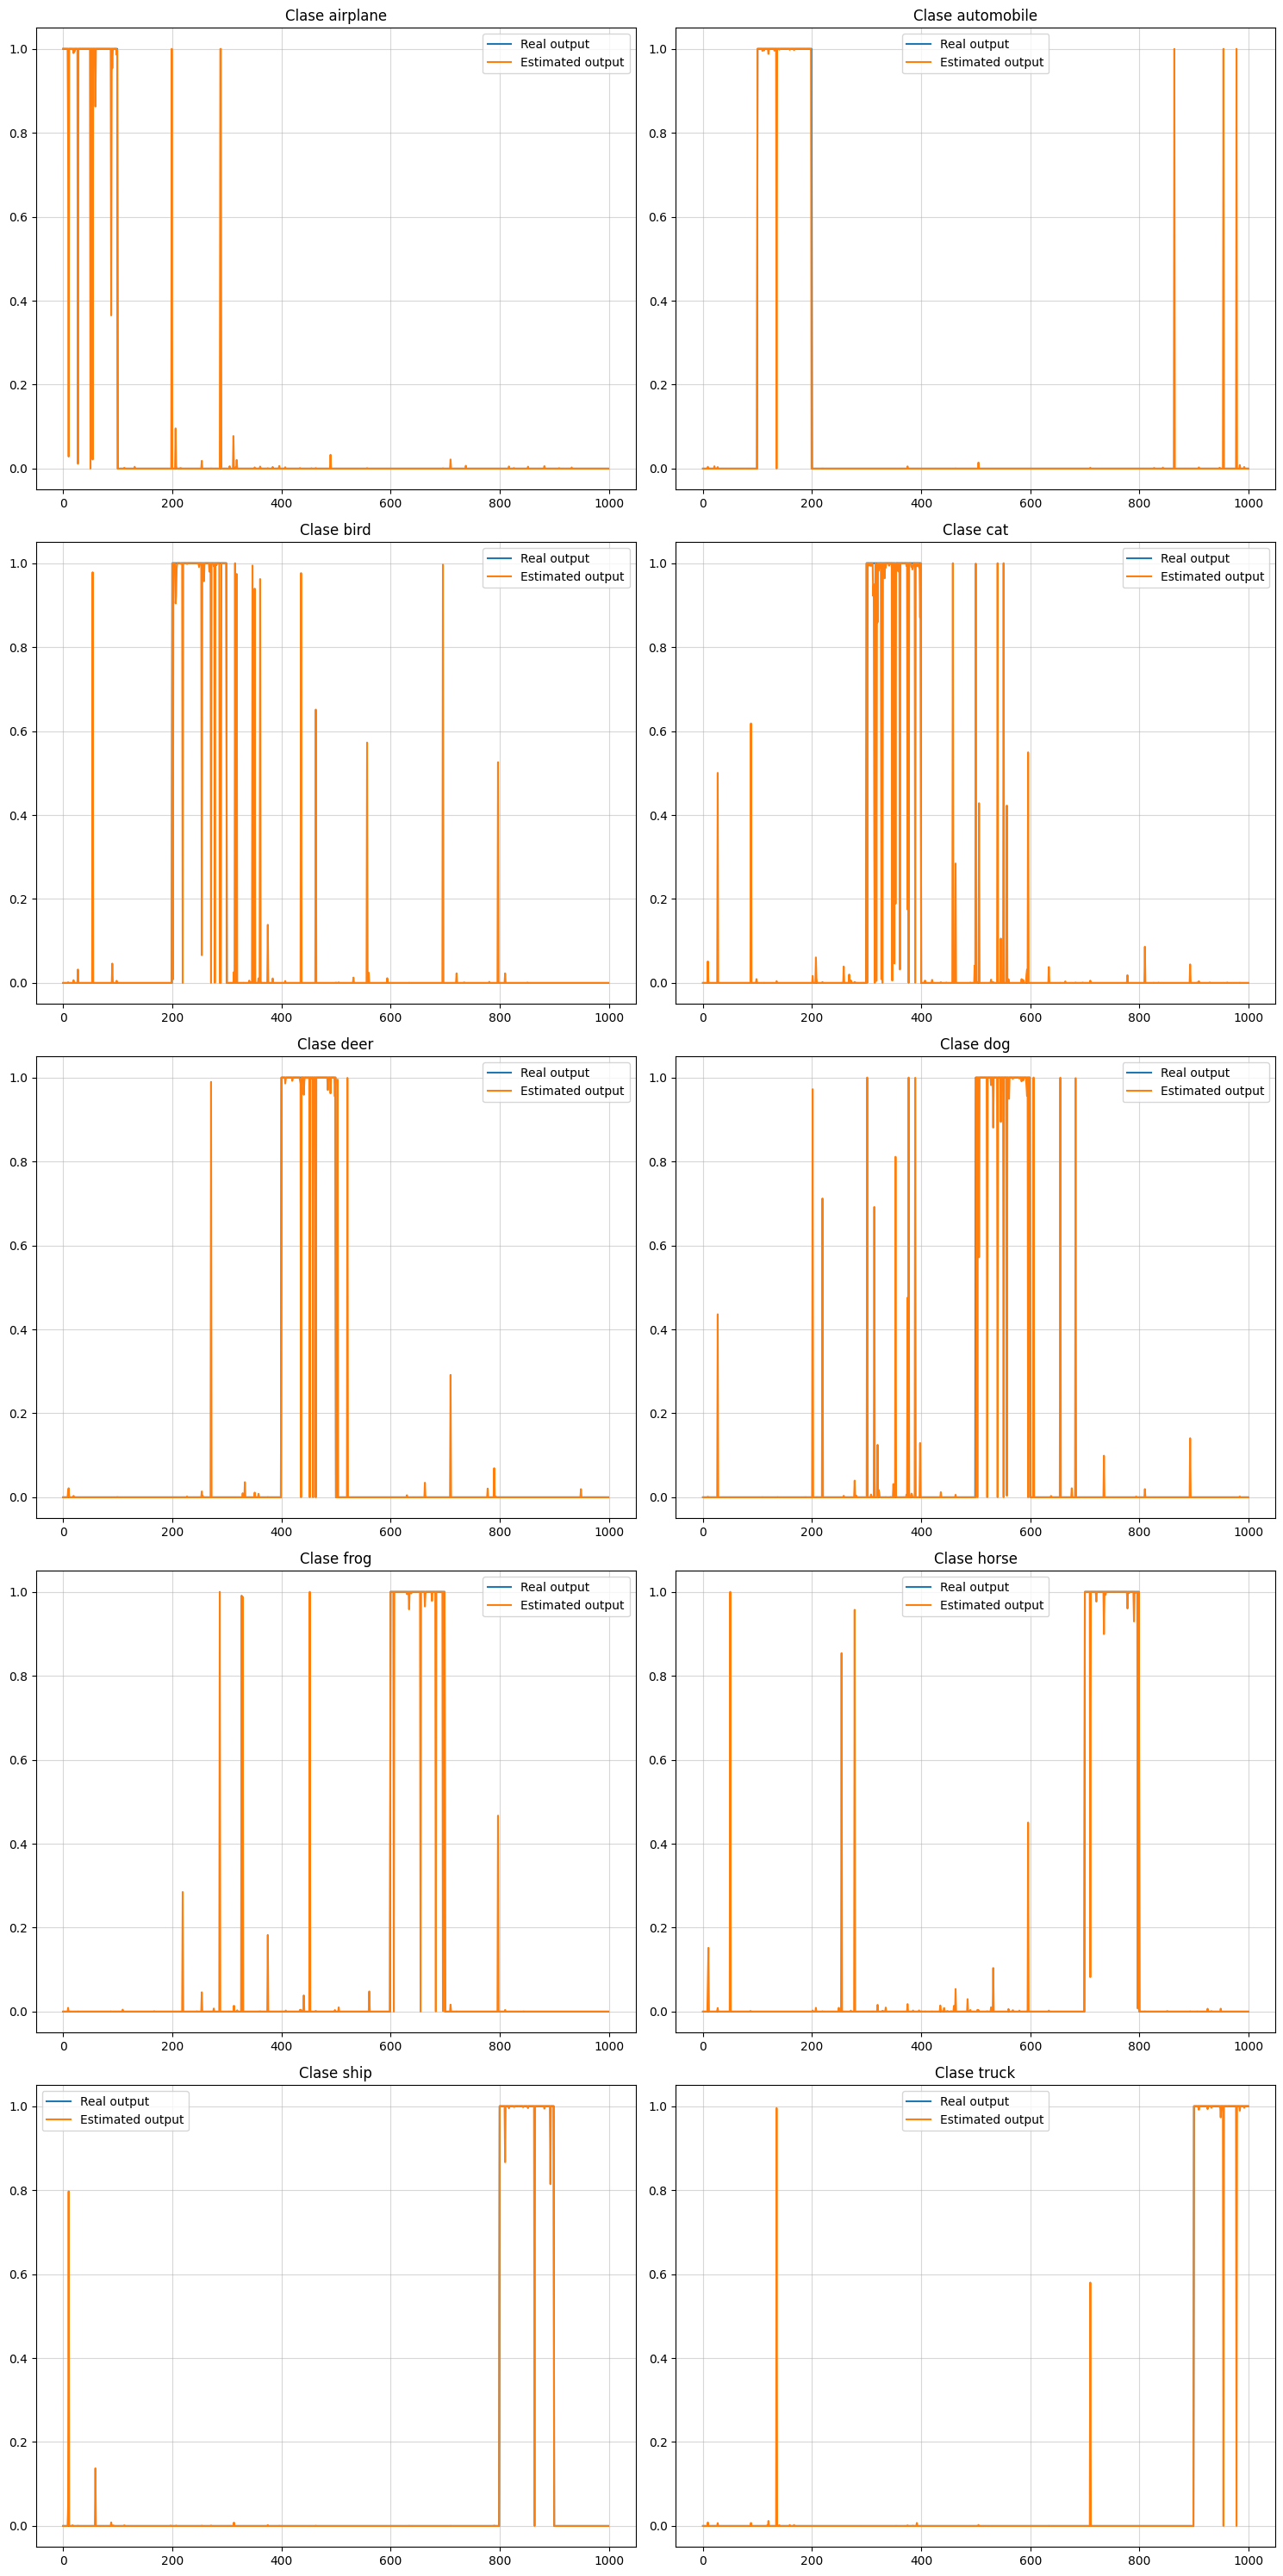

In [12]:
p = y.shape[1]
filas = p // 3 + (p % 3 > 0)  # Calcula el número de filas necesarias
fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Crea una gráfica con 'filas' filas y 3 columnas

axs = axs.ravel()  # Convierte el array de ejes en un array 1D para facilitar su manejo

for i in range(p):
    axs[i].plot(t, y[:, i], label="Real output")  # Estimated output vs real output
    axs[i].plot(t, y_prob_1[:, i], label="Estimated output")
    axs[i].legend()
    axs[i].grid(alpha=0.5)
    axs[i].set_title(f"Clase {labels[i]}")

plt.tight_layout()
plt.show()

In [13]:
labels

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

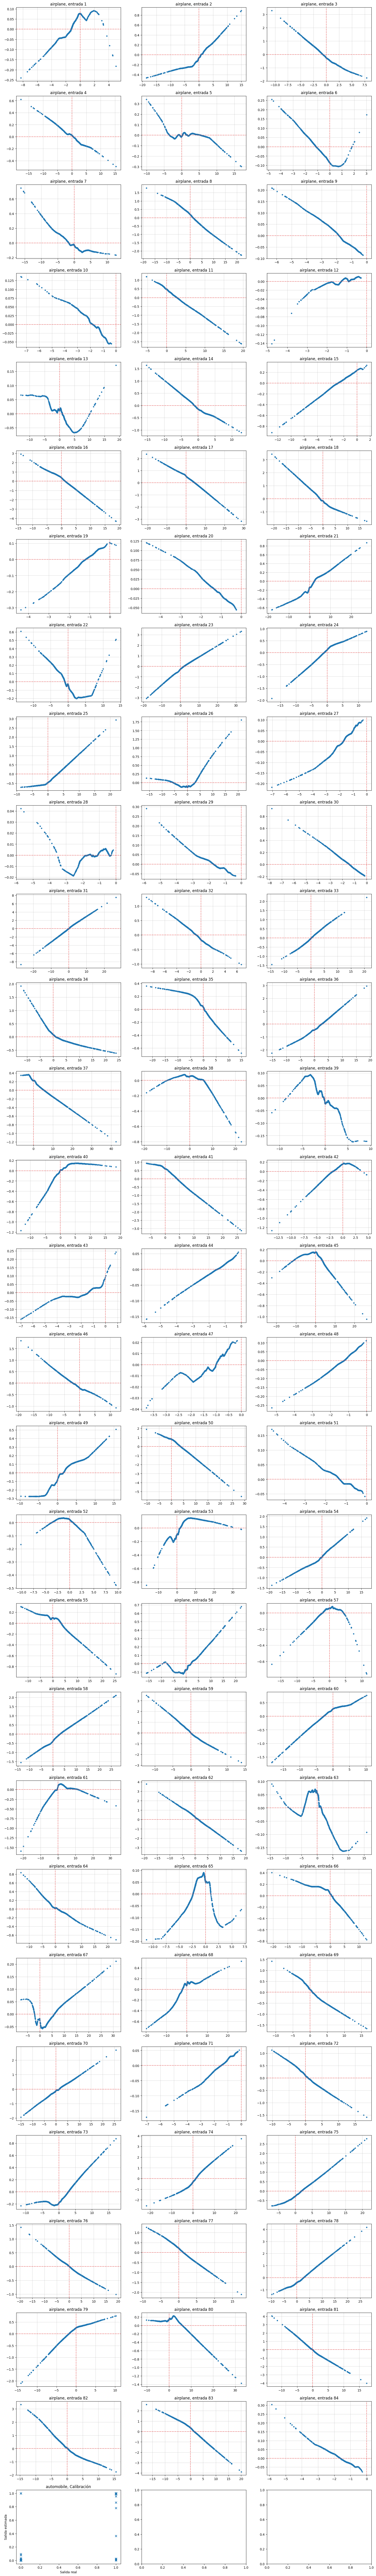

In [14]:
# Supongamos que 'n' es el número de tensores en X
n = X.shape[1]

# Plotting the decomposition
i = 0
fig, axs = plt.subplots(n // 3 + 1, 3, figsize=(20, 5 * (n // 3 + 1)))
for j in range(n):
    row = j // 3
    col = j % 3
    axs[row, col].axhline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].axvline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].scatter(
        X[:, j], y_e_1[:, j, i] - y_e_1[:, j, i].mean(), s=10
    )  # Estimated nonlinear contribution of xj on the output
    axs[row, col].set_title(f"{labels[i]}, entrada {j+1}")
    axs[row, col].grid(alpha=0.5)

axs[n // 3, n % 3].scatter(
    y[:, i].cpu(), y_prob_1[:, i].cpu(), marker="x"
)  # Calibration plot real output vs estimated output
axs[n // 3, n % 3].set_title(f"{labels[i+1]}, Calibración")
axs[n // 3, n % 3].set_xlabel("Salida real")
axs[n // 3, n % 3].set_ylabel("Salida estimada")
plt.show()

In [15]:
labels

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

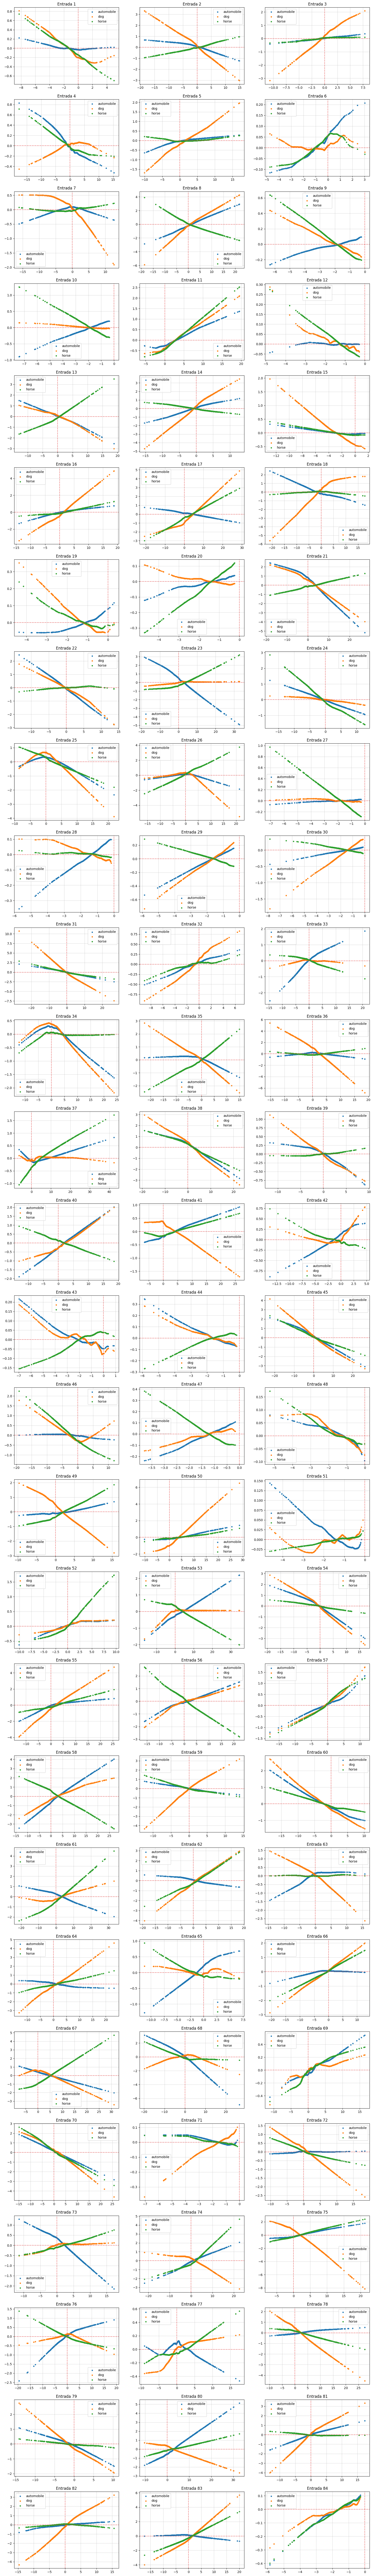

In [16]:
# Supongamos que 'n' es el número de tensores en X
n = X.shape[1]

#  Solicitando las clases que se desean visualizar
i1 = 1
i2 = 5
i3 = 7

# Creando los subgráficos
fig, axs = plt.subplots(n // 3, 3, figsize=(20, 5 * (n // 3 + 1)))

# Plotting the decomposition for all three classes
for j in range(n):
    row = j // 3
    col = j % 3
    axs[row, col].axhline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].axvline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].scatter(
        X[:, j], y_e_1[:, j, i1] - y_e_1[:, j, i1].mean(), label=f"{labels[i1]}", s=10
    )  # Estimated nonlinear contribution of xj on the output for class i1
    axs[row, col].scatter(
        X[:, j], y_e_1[:, j, i2] - y_e_1[:, j, i2].mean(), label=f"{labels[i2]}", s=10
    )  # Estimated nonlinear contribution of xj on the output for class i2
    axs[row, col].scatter(
        X[:, j], y_e_1[:, j, i3] - y_e_1[:, j, i3].mean(), label=f"{labels[i3]}", s=10
    )  # Estimated nonlinear contribution of xj on the output for class i3
    axs[row, col].set_title(f"Entrada {j+1}")
    axs[row, col].legend()
    axs[row, col].grid(alpha=0.5)
plt.show() 